<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day10_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_regression, mutual_info_regression,
    RFE, RFECV, SelectFromModel
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"

from sklearn.datasets import fetch_openml
housing = fetch_openml(name='house_prices', as_frame=True, parser='auto')
df = housing.frame

In [3]:
print(f"{df.shape[0]} houses, {df.shape[1]} columns")

1460 houses, 81 columns


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(df.dtypes.value_counts())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

object     43
int64      35
float64     3
Name: count, dtype: int64

Numeric columns: 38
Categorical columns: 43


In [6]:
#Target Variables
target_col = 'SalePrice'

print(f"Target: {target_col}")
print(f"Min: {df[target_col].min()}")
print(f"Max: {df[target_col].max()}")
print(f"Mean: {df[target_col].mean()}")
print(f"Median: {df[target_col].median()}")
print(f"Std: {df[target_col].std()}")

Target: SalePrice
Min: 34900
Max: 755000
Mean: 180921.19589041095
Median: 163000.0
Std: 79442.50288288663


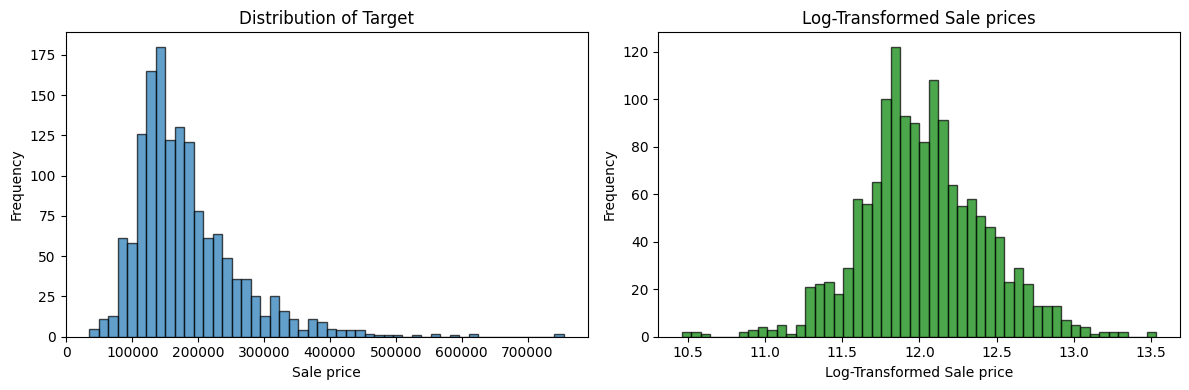

In [7]:
#Visualize target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title("Distribution of Target")
axes[0].set_xlabel("Sale price")
axes[0].set_ylabel("Frequency")

axes[1].hist(np.log1p(df[target_col]), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Log-Transformed Sale prices')
axes[1].set_xlabel('Log-Transformed Sale price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
#missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percent': missing_pct
}).sort_values('Missing', ascending=False)

print(missing_df[missing_df['Missing'] > 0].head(20))

              Missing  Percent
PoolQC           1453     99.5
MiscFeature      1406     96.3
Alley            1369     93.8
Fence            1179     80.8
FireplaceQu       690     47.3
LotFrontage       259     17.7
GarageFinish       81      5.5
GarageQual         81      5.5
GarageYrBlt        81      5.5
GarageType         81      5.5
GarageCond         81      5.5
BsmtExposure       38      2.6
BsmtFinType2       38      2.6
BsmtCond           37      2.5
BsmtFinType1       37      2.5
BsmtQual           37      2.5
MasVnrArea          8      0.5
MasVnrType          8      0.5
Electrical          1      0.1


Prepare the Data

In [9]:
x = df.drop(target_col, axis=1)
y = df[target_col]

y_log = np.log1p(y)

print(f"Features: {x.shape[1]}")
print(f"Samples: {x.shape[0]}")

Features: 80
Samples: 1460


In [10]:
numeric_cols= x.select_dtypes(include=[np.number]).columns.tolist()
if 'Id' in numeric_cols:
  numeric_cols.remove('Id')

x_numeric = x[numeric_cols].copy()

print(f"Numeric Features: {len(numeric_cols)}")
print(f"\nsample Features: {numeric_cols[:10]}. . . ")

Numeric Features: 36

sample Features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']. . . 


In [11]:
#Impute missing values with median
imputer = SimpleImputer(strategy='median')
x_imputed = pd.DataFrame(
    imputer.fit_transform(x_numeric),
    columns=numeric_cols
)

In [12]:
# Now let's also encode important categorical features
important_cats = ['Neighborhood', 'BldgType', 'HouseStyle', 'ExterQual', 'KitchenQual']
available_cats = [col for col in important_cats if col in x.columns]

print(f"Adding categorical features: {available_cats}")

# One-hot encode
if available_cats:
    x_cats = pd.get_dummies(x[available_cats], drop_first=True)
    x_full = pd.concat([x_imputed, x_cats], axis=1)
else:
    x_full = x_imputed

print(f"\nTotal features after encoding: {x_full.shape[1]}")

Adding categorical features: ['Neighborhood', 'BldgType', 'HouseStyle', 'ExterQual', 'KitchenQual']

Total features after encoding: 77


In [13]:
#Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_log, test_size=0.2, random_state=42
)

print(f"Train: {x_train.shape[0]}")
print(f"Test: {x_test.shape[0]}")

Train: 1168
Test: 292


In [14]:
#Scaling Features
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=x_train.columns,
    index=x_train.index
)

x_test_scaled = pd.DataFrame(
    scaler.transform(x_test),
    columns=x_test.columns,
    index=x_test.index
)

print(x_train_scaled.describe())
print(x_test_scaled.describe())

         MSSubClass   LotFrontage       LotArea   OverallQual   OverallCond  \
count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
mean   6.995926e-17  2.798370e-16  2.281280e-17 -5.170902e-17 -2.281280e-16   
std    1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00  1.000428e+00   
min   -8.667643e-01 -2.185871e+00 -8.730685e-01 -3.746488e+00 -4.109739e+00   
25%   -8.667643e-01 -4.494336e-01 -2.884669e-01 -8.204446e-01 -5.241741e-01   
50%   -1.611086e-01 -4.871723e-02 -1.013172e-01 -8.893368e-02 -5.241741e-01   
75%    3.093285e-01  3.965232e-01  9.394519e-02  6.425772e-01  3.722173e-01   
max    3.131951e+00  1.081515e+01  1.901998e+01  2.837110e+00  3.061391e+00   

          YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1    BsmtFinSF2  \
count  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03  1.168000e+03   
mean  -1.417435e-15  4.653812e-15 -4.562560e-18  6.463627e-18 -4.410475e-17   
std    1.000428e+00  1.000428e+00  1.000428e+00  1.

Baseline - using all features

In [15]:
def evaluate_model(model, x_train, y_train, x_test, y_test, name='Model'):
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    #calculate metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"  Train RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
    print(f"  Test RMSE:  {rmse_test:.4f}, R²: {r2_test:.4f}")

    return {
        'Model': name,
        'Train RMSE': rmse_train,
        'Test RMSE': rmse_test,
    }

In [16]:
# Baseline with all features
print("BASELINE: All Features")
print("="*50)

results = []

baseline = LinearRegression()
results.append(evaluate_model(baseline, x_train_scaled, y_train, x_test_scaled, y_test, "All Features (Linear)"))

BASELINE: All Features
  Train RMSE: 0.1293, R²: 0.8904
  Test RMSE:  0.1384, R²: 0.8973


Filter Method 1 — Variance Threshold

In [17]:
#Check Variance of the features
variances = x_train_scaled.var().sort_values()

print("Features with lowest variance: ")
print(variances.head(10))

print("Features with highest variance: ")
print(variances.tail(10))

Features with lowest variance: 
Neighborhood_Somerst    1.000857
Neighborhood_Blueste    1.000857
Neighborhood_StoneBr    1.000857
BldgType_TwnhsE         1.000857
LowQualFinSF            1.000857
Neighborhood_OldTown    1.000857
Neighborhood_ClearCr    1.000857
2ndFlrSF                1.000857
WoodDeckSF              1.000857
Neighborhood_BrkSide    1.000857
dtype: float64
Features with highest variance: 
BsmtHalfBath            1.000857
Neighborhood_BrDale     1.000857
HouseStyle_SLvl         1.000857
Neighborhood_SWISU      1.000857
GarageCars              1.000857
Neighborhood_Veenker    1.000857
BsmtFinSF2              1.000857
FullBath                1.000857
HalfBath                1.000857
Neighborhood_Gilbert    1.000857
dtype: float64


In [18]:
#Applying Variance Threshold
variance_threshold = 0.1

selector_var = VarianceThreshold(threshold=variance_threshold)
x_train_var = selector_var.fit_transform(x_train_scaled)
x_test_var = selector_var.transform(x_test_scaled)

#Get selected features names
selected_features_var = x_train_scaled.columns[selector_var.get_support()].tolist()

print(f"Variance Threshold: {variance_threshold}")
print(f"  Before: {x_train_scaled.shape[1]} features")
print(f"  After: {x_train_var.shape[1]} features")
print(f"  Removed: {x_train_scaled.shape[1] - x_train_var.shape[1]} features")

Variance Threshold: 0.1
  Before: 77 features
  After: 77 features
  Removed: 0 features


In [19]:
# Evaluate
print("\nFILTER: Variance Threshold")
print("="*50)

model_var = LinearRegression()
results.append(evaluate_model(model_var, x_train_var, y_train, x_test_var, y_test, "Variance Threshold"))


FILTER: Variance Threshold
  Train RMSE: 0.1293, R²: 0.8904
  Test RMSE:  0.1384, R²: 0.8973


Filter Method 2 - Correlated with Target

In [20]:
correlations = x_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 20 features by correlation")
print(correlations.head(20))

Top 20 features by correlation
OverallQual             0.807946
GrLivArea               0.689012
GarageCars              0.684451
GarageArea              0.654520
TotalBsmtSF             0.597214
FullBath                0.583747
ExterQual_TA            0.583589
1stFlrSF                0.580948
YearBuilt               0.576725
YearRemodAdd            0.562152
KitchenQual_TA          0.527992
TotRmsAbvGrd            0.520082
ExterQual_Gd            0.498680
Fireplaces              0.481761
GarageYrBlt             0.481453
MasVnrArea              0.419978
KitchenQual_Gd          0.395899
Neighborhood_NridgHt    0.346842
BsmtFinSF1              0.340878
WoodDeckSF              0.340702
dtype: float64


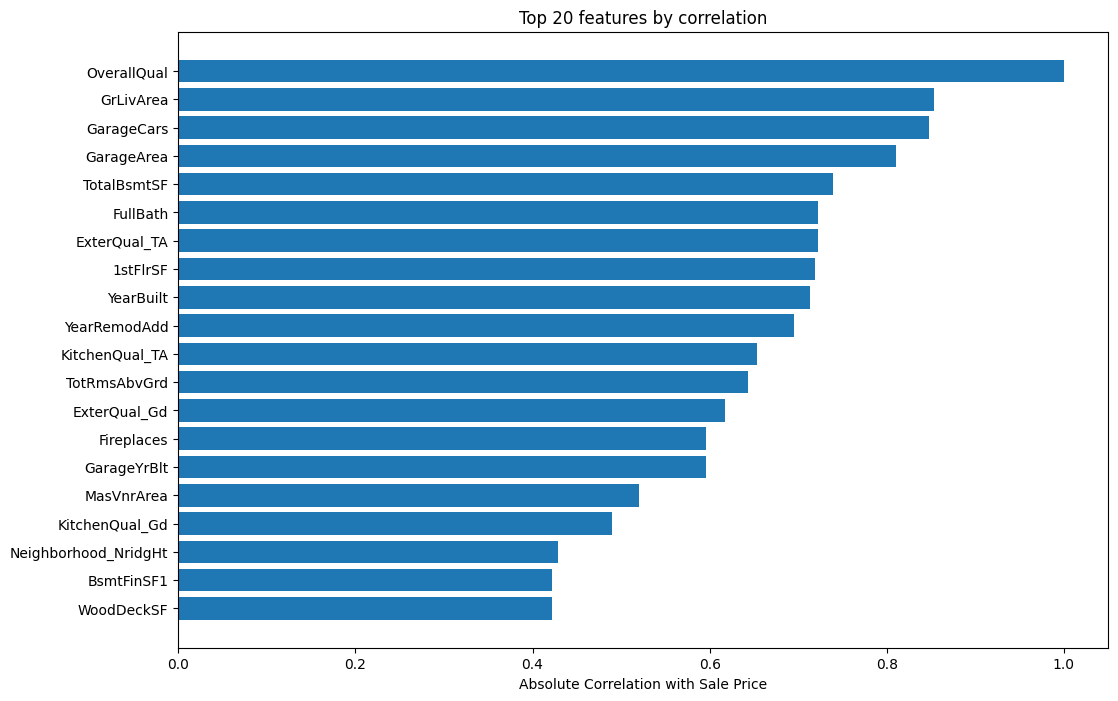

In [21]:
#visualizing the correlations
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = correlations.head(20)
colors = plt.cm.RdYlGn(top_20.values / top_20.max())

bars = ax.barh(range(len(top_20)), top_20.values / top_20.max())
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.set_xlabel('Absolute Correlation with Sale Price')
ax.set_title("Top 20 features by correlation")
ax.invert_yaxis()

plt.tight_layout
plt.show()

In [22]:
#Select top K features by correlation
k_corr = 20
top_corr_features = correlations.head(k_corr).index.tolist()

x_train_corr = x_train_scaled[top_corr_features]
x_test_corr = x_test_scaled[top_corr_features]

print(f"Selected Features: {k_corr}")
print(f"  Before: {x_train_scaled.shape[1]} features")

Selected Features: 20
  Before: 77 features


In [23]:
#Evaluate
model_corr = LinearRegression()

results.append(evaluate_model(model_corr, x_train_corr,y_train,  x_test_corr, y_test, "top 20 correlations"))

  Train RMSE: 0.1583, R²: 0.8356
  Test RMSE:  0.1634, R²: 0.8569


Method 3: SelectKBest with F-regression

In [24]:
k_best = 20

selector_kbest = SelectKBest(score_func=f_regression, k = k_best)
x_train_kbest = selector_kbest.fit_transform(x_train_scaled, y_train)
x_test_kbest = selector_kbest.transform(x_test_scaled)

#Get selected features
kbest_features = x_train_scaled.columns[selector_kbest.get_support()].tolist()

print(f"Selected Features: {k_best}")
print(kbest_features)


Selected Features: 20
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'Neighborhood_NridgHt', 'ExterQual_Gd', 'ExterQual_TA', 'KitchenQual_Gd', 'KitchenQual_TA']


In [25]:
#Feature scores
feature_scores = pd.DataFrame({
    'feature': x_train_scaled.columns,
    'F-score': selector_kbest.scores_,
}).sort_values('F-score', ascending=False)

print('\nTop 20 by F-score')
print(feature_scores.head(20).to_string(index=False))


Top 20 by F-score
             feature     F-score
         OverallQual 2192.066010
           GrLivArea 1053.840141
          GarageCars 1027.680019
          GarageArea  873.874814
         TotalBsmtSF  646.429613
            FullBath  602.704645
        ExterQual_TA  602.209513
            1stFlrSF  594.000704
           YearBuilt  581.109414
        YearRemodAdd  538.714188
      KitchenQual_TA  450.696155
        TotRmsAbvGrd  432.322442
        ExterQual_Gd  385.939270
          Fireplaces  352.414855
         GarageYrBlt  351.827309
          MasVnrArea  249.704013
      KitchenQual_Gd  216.721973
Neighborhood_NridgHt  159.450981
          BsmtFinSF1  153.299988
          WoodDeckSF  153.120729


In [26]:
model_kbest = LinearRegression()
results.append(evaluate_model(model_kbest, x_train_kbest,y_train, x_test_kbest, y_test, "SelectKBest (k=20)"))

  Train RMSE: 0.1583, R²: 0.8356
  Test RMSE:  0.1634, R²: 0.8569


Method 4: Mutual information

In [27]:
selector_mi = SelectKBest(score_func=mutual_info_regression, k=k_best)
x_train_mi = selector_mi.fit_transform(x_train_scaled, y_train)
x_test_mi = selector_mi.transform(x_test_scaled)

mi_features = x_train_scaled.columns[selector_mi.get_support()]

print(f"Selected Features: {k_best}")
print(mi_features)

Selected Features: 20
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'OpenPorchSF', 'ExterQual_Gd', 'ExterQual_TA',
       'KitchenQual_TA'],
      dtype='object')


In [28]:
#Comparing F-Regression with mutual information
mi_scores = pd.DataFrame({
    'feature': x_train_scaled.columns,
    'MI-score': selector_mi.scores_
}).sort_values('MI-score', ascending=False)

#Merge with F-scores
comparison = feature_scores.merge(mi_scores, on='feature')
comparison['F-Rank'] = comparison['F-score'].rank
comparison['MI-Rank'] = comparison['MI-score'].rank

print(f"Top 15 features - F-score vs Mutual information:")
print(comparison.head(15).to_string(index=False))

Top 15 features - F-score vs Mutual information:
       feature     F-score  MI-score                                                                                                                                                                                                                                                                                    F-Rank                                                                                                                                                                                                                                                   MI-Rank
   OverallQual 2192.066010  0.529280 <bound method NDFrame.rank of 0     2192.066010\n1     1053.840141\n2     1027.680019\n3      873.874814\n4      646.429613\n         ...     \n72       0.403908\n73       0.397445\n74       0.352540\n75       0.178929\n76       0.133618\nName: F-score, Length: 77, dtype: float64> <bound method NDFrame.rank of 0     0.529280\n1     0.446834\n2

In [29]:
model_mi = LinearRegression()
results.append(evaluate_model(model_mi, x_train_mi, y_train, x_test_mi, y_test, "Mutual Info (k=20)"))

  Train RMSE: 0.1577, R²: 0.8369
  Test RMSE:  0.1683, R²: 0.8483


Method 5: Wrapper Method - Recursive feature Elimination (RFE)



In [30]:
print("Running RFE")

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=20, step=5)
rfe.fit(x_train_scaled, y_train)

rfe_features = x_train_scaled.columns[rfe.support_].tolist()

print(f"Selected Features: {len(rfe_features)} Features")
print(rfe_features)

Running RFE
Selected Features: 20 Features
['OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_2Story']


In [31]:
rfe_ranking = pd.DataFrame({
    'Feature': x_train_scaled.columns,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("RFE Features by Ranking")
print(rfe_ranking.head(20).to_string(index=False))

RFE Features by Ranking
             Feature  Ranking
         OverallQual        1
         OverallCond        1
           YearBuilt        1
         TotalBsmtSF        1
           GrLivArea        1
            HalfBath        1
            FullBath        1
        BsmtFullBath        1
        KitchenAbvGr        1
          GarageCars        1
        TotRmsAbvGrd        1
          Fireplaces        1
     BldgType_TwnhsE        1
      BldgType_Twnhs        1
Neighborhood_StoneBr        1
Neighborhood_Crawfor        1
Neighborhood_NridgHt        1
Neighborhood_NoRidge        1
Neighborhood_Somerst        1
   HouseStyle_2Story        1


In [34]:
#Evaluate RFE
x_train_rfe = x_train_scaled[rfe_features]
x_test_rfe = x_test_scaled[rfe_features]

model_rfe = LinearRegression()
results.append(evaluate_model(model_rfe, x_train_rfe, y_train, x_test_rfe, y_test, "RFE (n=20)" ))

  Train RMSE: 0.1403, R²: 0.8709
  Test RMSE:  0.1446, R²: 0.8879


In [35]:
#RFECV - RFE with cross validation to find optimal no.  of features
rfecv = RFECV(estimator=LinearRegression(), step=5, cv=5, scoring='r2', min_features_to_select=5)
rfecv.fit(x_train_scaled, y_train)

print(f"Optimal no. of features: {rfecv.n_features_}")

Optimal no. of features: 57


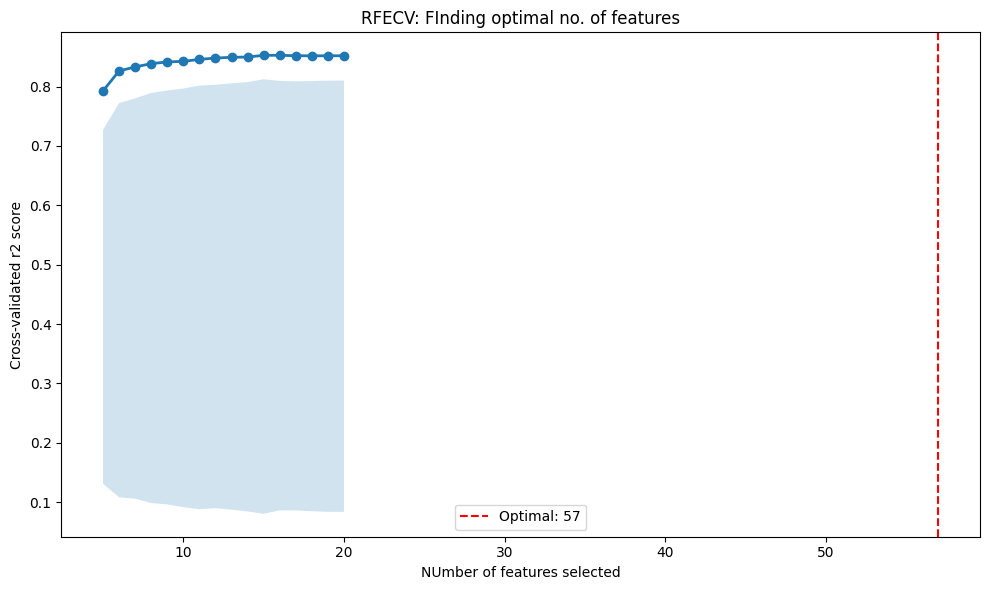

In [39]:
#plot
fig, ax = plt.subplots(figsize=(10, 6))

n_features_range = range(rfecv.min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + rfecv.min_features_to_select)
ax.plot(n_features_range, rfecv.cv_results_['mean_test_score'], 'o-', linewidth=2)
ax.fill_between(n_features_range, rfecv.cv_results_['mean_test_score'] - rfecv
                .cv_results_['std_test_score'],
                rfecv.cv_results_['std_test_score'] + rfecv.cv_results_['std_test_score'], alpha=0.2)
ax.axvline(x=rfecv.n_features_, color='r', linestyle='--', label=f"Optimal: {rfecv.n_features_}")
ax.set_xlabel("NUmber of features selected")
ax.set_ylabel("Cross-validated r2 score")
ax.set_title("RFECV: FInding optimal no. of features")
ax.legend()

plt.tight_layout()
plt.show()

Embedding  - Lasso Regularization

Lasso (L1) shrinks some coefficients to exactly zero — automatic feature selection!

In [40]:
#Finding optimal lasso alpha with LassoCV

lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(x_train_scaled, y_train)

print(f"Optimal data: {lasso_cv.alpha_:.6f}")

Optimal data: 0.002744


In [44]:
#Finding out which features Lasso kept
lasso_coef = pd.DataFrame({
    'Feature': x_train_scaled.columns,
    'Coefficient': lasso_cv.coef_
})

lasso_selected = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
lass0_eliminated = lasso_coef[lasso_coef['Coefficient'] == 0]

print(f"Features Lasso kept: {lasso_coef.shape[0]}")
print(f"Features lasso eliminated: {lass0_eliminated.shape[0]}")
print(f"\n Top 20 features by lasso coefficient")
print(lasso_selected.head(20).to_string(index=False))

Features Lasso kept: 77
Features lasso eliminated: 22

 Top 20 features by lasso coefficient
             Feature  Coefficient
         OverallQual     0.094851
           GrLivArea     0.082858
           YearBuilt     0.074841
          GarageCars     0.053446
         OverallCond     0.045476
        BsmtFullBath     0.033152
Neighborhood_NridgHt     0.031587
          Fireplaces     0.026407
Neighborhood_Crawfor     0.023880
        TotRmsAbvGrd     0.022666
Neighborhood_StoneBr     0.022338
      BldgType_Twnhs    -0.020417
        YearRemodAdd     0.018420
Neighborhood_Somerst     0.018183
            FullBath     0.016965
         TotalBsmtSF     0.016075
Neighborhood_NoRidge     0.015575
Neighborhood_Edwards    -0.015076
         ScreenPorch     0.014540
            HalfBath     0.014373


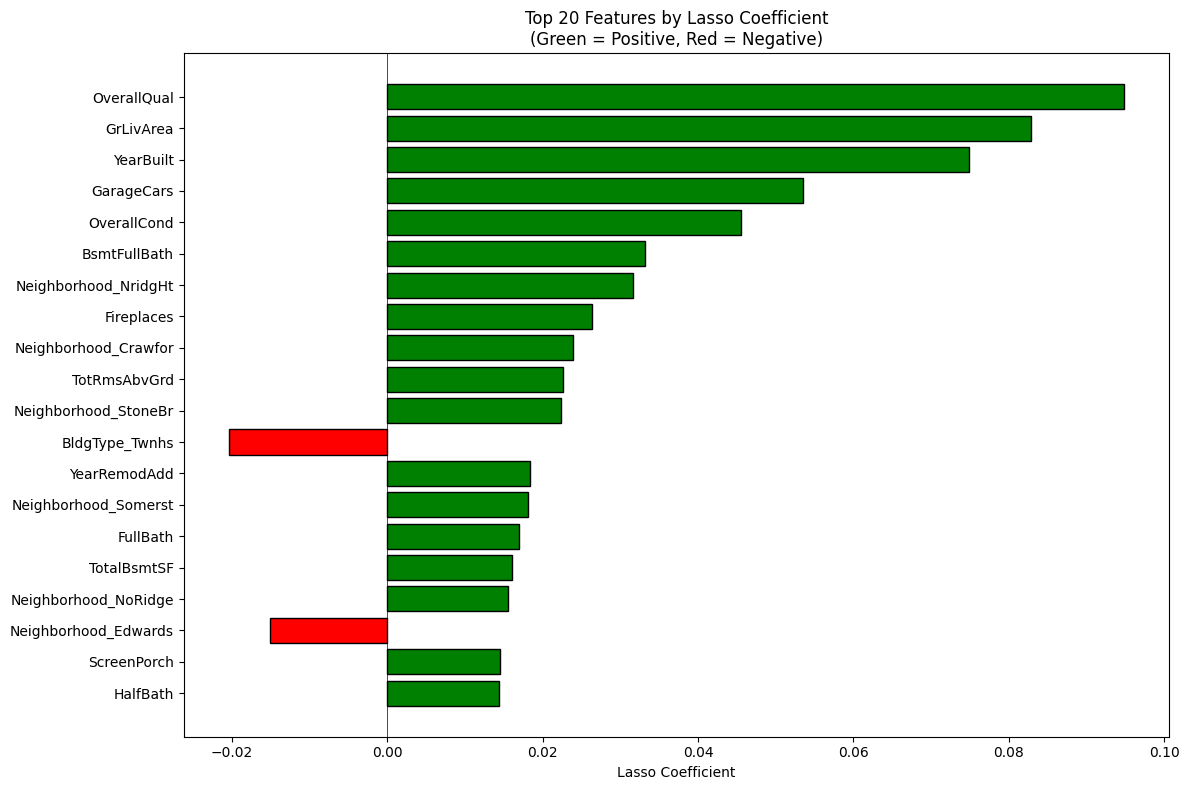

In [45]:
# Visualize Lasso coefficients
fig, ax = plt.subplots(figsize=(12, 8))

top_lasso = lasso_selected.head(20)
colors = ['green' if x > 0 else 'red' for x in top_lasso['Coefficient']]

ax.barh(range(len(top_lasso)), top_lasso['Coefficient'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_lasso)))
ax.set_yticklabels(top_lasso['Feature'])
ax.set_xlabel('Lasso Coefficient')
ax.set_title('Top 20 Features by Lasso Coefficient\n(Green = Positive, Red = Negative)')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [52]:
# Evaluate Lasso
print("\nEMBEDDED: Lasso Regularization")
print("="*50)

lasso_features = lasso_selected['Feature'].tolist()
x_train_lasso = x_train_scaled[lasso_features]
x_test_lasso = x_test_scaled[lasso_features]

model_lasso = LinearRegression()  # Use regular LR on Lasso-selected features
results.append(evaluate_model(model_lasso, x_train_lasso, y_train, x_test_lasso, y_test, f"Lasso (n={len(lasso_features)})"))


EMBEDDED: Lasso Regularization
  Train RMSE: 0.1301, R²: 0.8890
  Test RMSE:  0.1381, R²: 0.8978


Embbeded method - Tree-based Feature importance

In [54]:
# Random Forest Feature Importance
print("Training Random Forest for feature importance...")

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train_scaled, y_train)

# Feature importances
rf_importance = pd.DataFrame({
    'Feature': x_train_scaled.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features by Random Forest Importance:")
print(rf_importance.head(20).to_string(index=False))

Training Random Forest for feature importance...

Top 20 Features by Random Forest Importance:
     Feature  Importance
 OverallQual    0.552906
   GrLivArea    0.117321
 TotalBsmtSF    0.050089
  GarageCars    0.042601
  GarageArea    0.030449
  BsmtFinSF1    0.024803
    1stFlrSF    0.024113
   YearBuilt    0.022673
     LotArea    0.017701
 OverallCond    0.013481
YearRemodAdd    0.011945
 LotFrontage    0.008151
    2ndFlrSF    0.007694
   BsmtUnfSF    0.007647
 OpenPorchSF    0.007646
  Fireplaces    0.006913
 GarageYrBlt    0.005653
      MoSold    0.005074
  WoodDeckSF    0.004501
  MSSubClass    0.003556


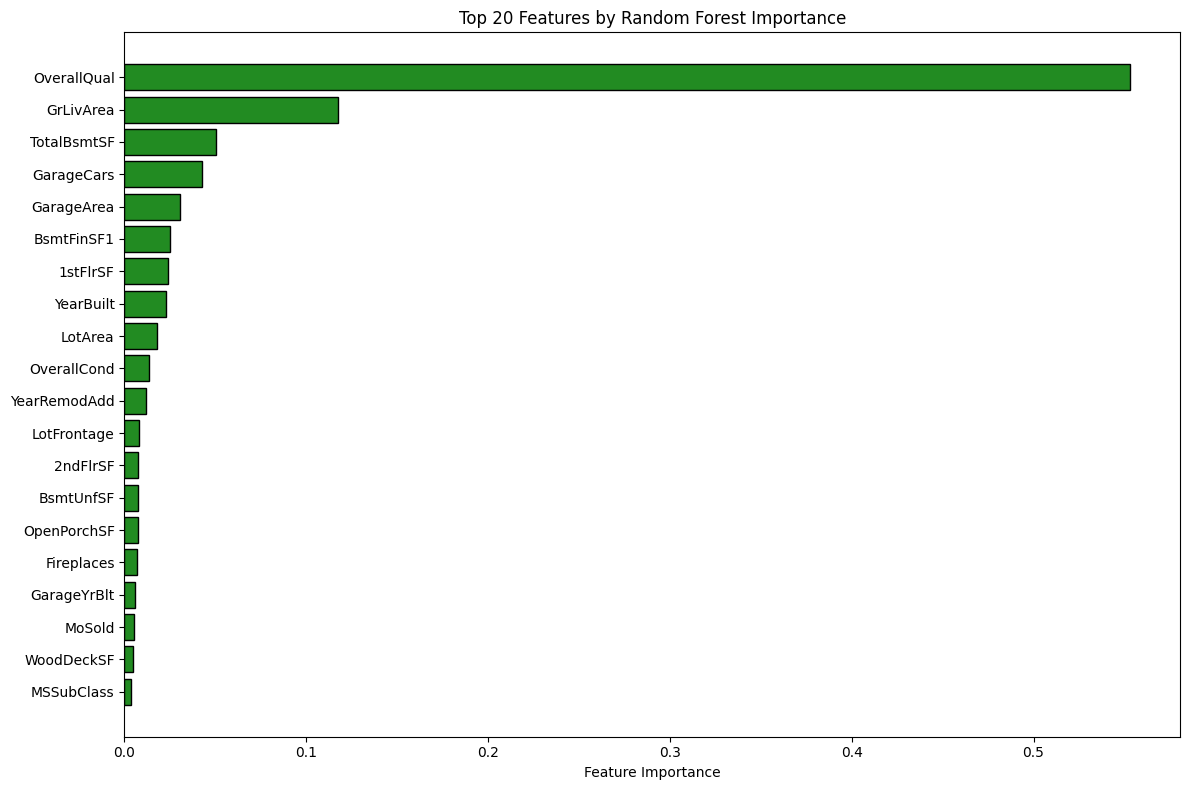

In [55]:
# Visualize RF importance
fig, ax = plt.subplots(figsize=(12, 8))

top_rf = rf_importance.head(20)
ax.barh(range(len(top_rf)), top_rf['Importance'], color='forestgreen', edgecolor='black')
ax.set_yticks(range(len(top_rf)))
ax.set_yticklabels(top_rf['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Features by Random Forest Importance')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [58]:
# Select top 20 by RF importance
rf_top_features = rf_importance.head(20)['Feature'].tolist()

x_train_rf = x_train_scaled[rf_top_features]
x_test_rf = x_test_scaled[rf_top_features]

print("\nEMBEDDED: Random Forest Importance")
print("="*50)

model_rf_select = LinearRegression()
results.append(evaluate_model(model_rf_select, x_train_rf ,y_train, x_test_rf, y_test, "RF Importance (n=20)"))


EMBEDDED: Random Forest Importance
  Train RMSE: 0.1498, R²: 0.8528
  Test RMSE:  0.1546, R²: 0.8719


In [61]:
# SelectFromModel - automatic threshold
selector_sfm = SelectFromModel(rf, threshold='median')
x_train_sfm = selector_sfm.fit_transform(x_train_scaled, y_train)
x_test_sfm = selector_sfm.transform(x_test_scaled)

sfm_features = x_train_scaled.columns[selector_sfm.get_support()].tolist()

print(f"SelectFromModel (median threshold): {len(sfm_features)} features")

model_sfm = LinearRegression()
results.append(evaluate_model(model_sfm, x_train_sfm, y_train,x_test_sfm, y_test, f"SelectFromModel (n={len(sfm_features)})"))

SelectFromModel (median threshold): 39 features
  Train RMSE: 0.1403, R²: 0.8709
  Test RMSE:  0.1480, R²: 0.8826


Compare all the methods

In [62]:
# Create comparison dataframe
results_df = pd.DataFrame(results)

print("COMPARISON OF ALL FEATURE SELECTION METHODS")
print("="*80)
print(results_df.to_string(index=False))

COMPARISON OF ALL FEATURE SELECTION METHODS
                 Model  Train RMSE  Test RMSE
 All Features (Linear)    0.129284   0.138437
    Variance Threshold    0.129284   0.138437
   top 20 correlations    0.158314   0.163429
    SelectKBest (k=20)    0.158314   0.163429
    Mutual Info (k=20)    0.157681   0.168270
            RFE (n=20)    0.140301   0.144618
          Lasso (n=55)    0.130079   0.138090
  RF Importance (n=20)    0.149795   0.154592
SelectFromModel (n=39)    0.140274   0.148008


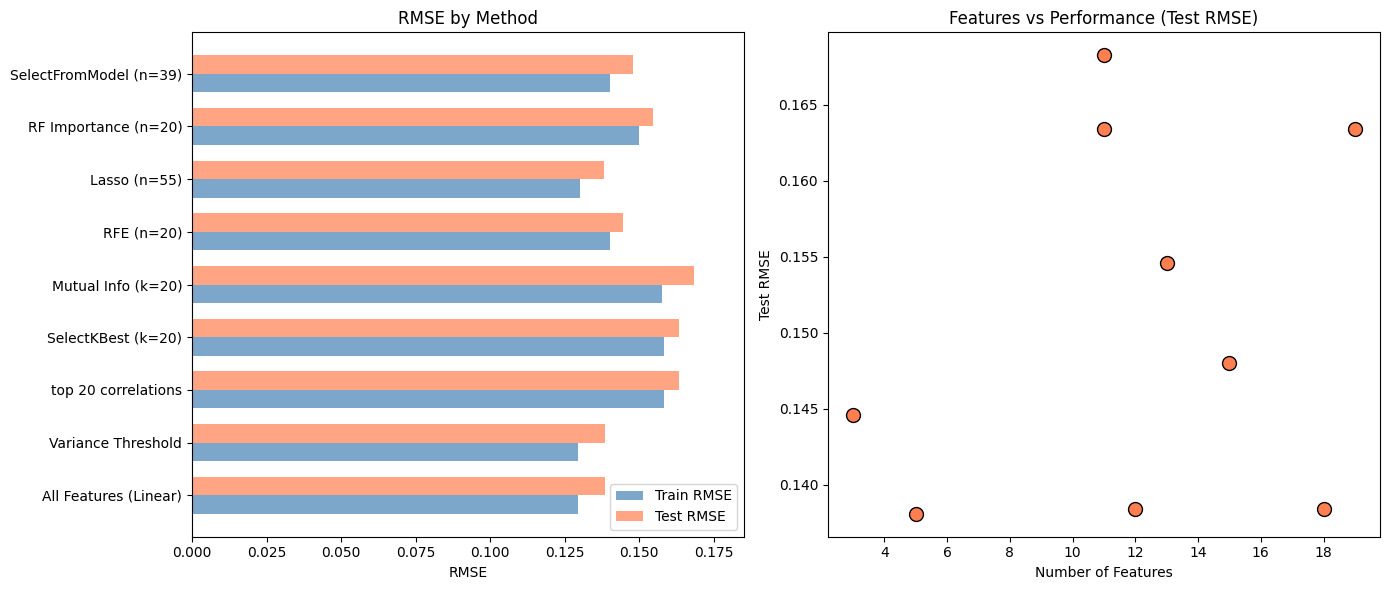

In [64]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Performance comparison (using RMSE as R² is not available in results_df)
x = range(len(results_df))
width = 0.35

axes[0].barh(x, results_df['Train RMSE'], height=width, label='Train RMSE', color='steelblue', alpha=0.7)
axes[0].barh([i + width for i in x], results_df['Test RMSE'], height=width, label='Test RMSE', color='coral', alpha=0.7)
axes[0].set_yticks([i + width/2 for i in x])
axes[0].set_yticklabels(results_df['Model'])
axes[0].set_xlabel('RMSE')
axes[0].set_title('RMSE by Method')
axes[0].legend()
axes[0].set_xlim(0, max(results_df['Train RMSE'].max(), results_df['Test RMSE'].max()) * 1.1)

# Features vs Performance (using Test RMSE)
# Note: To plot R² as originally intended, the 'evaluate_model' function needs to be updated to return R² scores.
axes[1].scatter(results_df['Model'].apply(lambda x: len(x.split('(')[0].strip()) if '(' in x else len(x.strip())), results_df['Test RMSE'], s=100, c='coral', edgecolors='black')
for i, row in results_df.iterrows():
    # Use Model name for annotation if 'n_features' is not directly available
    # Assuming the number of features can be extracted from the model name like 'Lasso (n=55)'
    if 'n=' in row['Model']:
        num_features = int(row['Model'].split('n=')[1].replace(')',''))
    elif 'k=' in row['Model']:
        num_features = int(row['Model'].split('k=')[1].replace(')',''))
    else:
        # Placeholder if feature count is not in model name, could be adjusted based on actual data
        num_features = len(x_train_scaled.columns) # Fallback to all features if not specified
    axes[1].annotate(row['Model'].split('(')[0].strip(),
                     (num_features, row['Test RMSE']),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Features vs Performance (Test RMSE)')

plt.tight_layout()
plt.show()

In [68]:
# Find best method
print("\nKEY INSIGHTS:")
print("="*60)

# Function to extract number of features from model name
def extract_n_features(model_name):
    if 'n=' in model_name:
        return int(model_name.split('n=')[1].replace(')',''))
    elif 'k=' in model_name:
        return int(model_name.split('k=')[1].replace(')',''))
    else:
        # For 'All Features (Linear)' and 'Variance Threshold', it's 77 features (from x_train_scaled.shape[1])
        return 77

results_df['n_features'] = results_df['Model'].apply(extract_n_features)

# Best performance (lowest Test RMSE)
best_rmse = results_df.loc[results_df['Test RMSE'].idxmin()]
print(f"\nBest Test Performance (lowest RMSE): {best_rmse['Model']}")
print(f"   Test RMSE = {best_rmse['Test RMSE']:.4f} with {best_rmse['n_features']} features")

# Best efficiency (lowest RMSE per feature)
results_df['efficiency_rmse'] = results_df['Test RMSE'] / results_df['n_features']
best_eff = results_df.loc[results_df['efficiency_rmse'].idxmin()]
print(f"\nMost Efficient (lowest RMSE/feature): {best_eff['Model']}")
print(f"   Test RMSE = {best_eff['Test RMSE']:.4f} with only {best_eff['n_features']} features (Efficiency: {best_eff['efficiency_rmse']:.4f})")

# Overfitting check (difference between Train RMSE and Test RMSE)
# A smaller gap means less overfitting.
results_df['overfit_gap_rmse'] = abs(results_df['Train RMSE'] - results_df['Test RMSE'])
least_overfit = results_df.loc[results_df['overfit_gap_rmse'].idxmin()]
print(f"\nLeast Overfitting (smallest RMSE gap): {least_overfit['Model']}")
print(f"   Train-Test RMSE gap: {least_overfit['overfit_gap_rmse']:.4f}")

# Clean up temporary columns
results_df.drop(columns=['n_features', 'efficiency_rmse', 'overfit_gap_rmse'], errors='ignore', inplace=True)


KEY INSIGHTS:

Best Test Performance (lowest RMSE): Lasso (n=55)
   Test RMSE = 0.1381 with 55 features

Most Efficient (lowest RMSE/feature): All Features (Linear)
   Test RMSE = 0.1384 with only 77 features (Efficiency: 0.0018)

Least Overfitting (smallest RMSE gap): RFE (n=20)
   Train-Test RMSE gap: 0.0043


## Key Takeaways

### Method Comparison:

| Method Type | Methods | Pros | Cons |
|-------------|---------|------|------|
| **Filter** | Variance, Correlation, SelectKBest, MI | Fast, model-agnostic | Ignores feature interactions |
| **Wrapper** | RFE, RFECV | Considers interactions | Slow, model-specific |
| **Embedded** | Lasso, Tree Importance | Built into training | Model-specific |

### When to Use What:

| Situation | Recommended Method |
|-----------|-------------------|
| Quick exploration | Correlation, Variance |
| Many features (100+) | Lasso, SelectKBest |
| Non-linear relationships | Mutual Information, RF Importance |
| Need optimal subset | RFECV |
| Robust selection | Consensus of multiple methods |

### Golden Rules:

1. **More features ≠ better** — often hurts performance
2. **Try multiple methods** and compare
3. **Use cross-validation** to validate selection
4. **Consider domain knowledge** — sometimes important features have low scores
5. **Check for multicollinearity** — correlated features can confuse selection
